# House Price prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections:
1. Data Inspection and Cleaning
2. Data Preparation
3. Linear Regression Model
4. Ridge Regression Model
5. Lasso Regression Model
6. Comparision and Evaluation


In [1]:
# libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# expand terminal width to 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# library versions

import matplotlib
import sklearn

print('numpy - version', np.__version__)
print('pandas - version', pd.__version__)
print('matplotlib - version', matplotlib.__version__)
print('seaborn - version', sns.__version__)
print('sklearn - version', sklearn.__version__)

numpy - version 1.21.5
pandas - version 1.4.1
matplotlib - version 3.5.1
seaborn - version 0.11.2
sklearn - version 1.0.2


## 1. Data Inspection and Cleaning

### Null values

In [3]:
# load and inspect the data
house_df = pd.read_csv('train.csv')
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# cannot have 'LotFrontage' if there's no 'LotArea'
house_df[(house_df['LotArea'] == 0) & (house_df['LotFrontage'] > 0)][['LotFrontage','LotArea']]

,LotFrontage,LotArea


In [6]:
# consider no 'LotFrontage' as 0
print('A:', house_df['LotFrontage'].isna().sum())
house_df['LotFrontage'].fillna(0, inplace=True)
print('B:', house_df['LotFrontage'].isna().sum())

A: 259
B: 0


In [7]:
house_df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [8]:
# none MasVnrType should have 0 MasVnrArea
print('A:', house_df['MasVnrType'].isna().sum())
print('B:', house_df[(house_df['MasVnrType'].isna()) & (house_df['MasVnrArea'] != 0)][['MasVnrType','MasVnrArea']])

A: 8
B:      MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN


In [9]:
# consider no 'MasVnrArea' as 0
house_df['MasVnrArea'].fillna(0, inplace=True)
house_df['MasVnrArea'].isna().sum()

0

In [10]:
# verify 'no basement' values
basement_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
for s in basement_cols:
    print(f'{s}: {house_df[s].isna().sum()}')
for s in basement_cols:
    if s.find('SF') >= 0:
        continue
    print()
    print(house_df[s].value_counts())

BsmtQual: 37
BsmtCond: 37
BsmtExposure: 38
BsmtFinType1: 37
BsmtFinSF1: 0
BsmtFinType2: 38
BsmtFinSF2: 0
BsmtUnfSF: 0
TotalBsmtSF: 0

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


In [11]:
house_df[(house_df.BsmtQual.isna()) |
         (house_df.BsmtCond.isna()) |
         (house_df.BsmtExposure.isna()) |
         (house_df.BsmtFinType1.isna()) |
         (house_df.BsmtFinType2.isna())][basement_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0


In [12]:
# if there's a basement, then one of the basement SF must be non-zero
house_df[(house_df.TotalBsmtSF > 0) & (house_df.BsmtFinSF1 == 0) & (house_df.BsmtFinSF2 == 0) & (house_df.BsmtUnfSF == 0)][basement_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [13]:
# if there's a basement, BsmtQual, BsmtCond and BsntExposure should no be NaN
house_df[(house_df.TotalBsmtSF > 0) & ((house_df.BsmtQual.isna()) | (house_df.BsmtCond.isna()) | (house_df.BsmtExposure.isna()))][basement_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
948,Gd,TA,NaN,Unf,0,Unf,0,936,936


In [14]:
house_df = house_df[~((house_df.TotalBsmtSF > 0) & ((house_df.BsmtQual.isna()) | (house_df.BsmtCond.isna()) | (house_df.BsmtExposure.isna())))]
house_df.shape

(1459, 81)

In [15]:
# if BsmtFinSF1 > 0 then BsmtFinType1 should not be NaN
house_df[ (house_df.BsmtFinSF1 > 0) & (house_df.BsmtFinType1.isna()) ][basement_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [16]:
# if BsmtFinSF2 > 0 then BsmtFinType2 should not be NaN
house_df[ ( house_df.BsmtFinSF2 > 0 ) & ( house_df.BsmtFinType2.isna() ) ][basement_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206


In [17]:
house_df = house_df[~( ( house_df.BsmtFinSF2 > 0 ) & ( house_df.BsmtFinType2.isna() ) )]
house_df.shape

(1458, 81)

In [18]:
# Electrical is NaN
house_df[house_df.Electrical.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [19]:
house_df = house_df[house_df.Electrical.notna()]
house_df.shape

(1457, 81)

In [20]:
# if no fireplaces, then there shouldn't be any FireplaceQu
house_df[( (house_df.Fireplaces == 0) & (house_df.FireplaceQu.notna()) )]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [21]:
house_df[( (house_df.Fireplaces > 0) & (house_df.FireplaceQu.isna()) )]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [22]:
# If there's no garage, then GarageType, GarageQal, GarageCond, GarageFinish shouldn't exist
house_df[(house_df.GarageArea > 0) & (house_df.GarageType.isna() | house_df.GarageQual.isna() | house_df.GarageCond.isna() | house_df.GarageFinish.isna())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [23]:
house_df[( (house_df.PoolArea > 0) & (house_df.PoolQC.isna()) )]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [24]:
house_df['GarageYrBlt'] = house_df.GarageYrBlt.astype('Int64')

In [25]:
house_df.GarageYrBlt.isna().sum()

81

In [26]:
house_df['MSSubClass'] = house_df.MSSubClass.astype('str')

### Ratings

In [27]:
# assign numeric values to numerical fields
rating_map = {
                                    'Typ' :7,
                    'GLQ':6,        'Min1':6,
    'Ex':5,         'ALQ':5,        'Min2':5,
    'Gd':4,         'BLQ':4,        'Mod' :4,          'GdPrv':4,
    'TA':3, 'Av':3, 'Rec':3,        'Maj1':3, 'Fin':4, 'MnPrv':3,
    'Fa':2, 'Mn':2, 'LwQ':2, 'Y':2, 'Maj2':2, 'RFn':3, 'GdWo' :2,
    'Po':1, 'No':1, 'Unf':1, 'P':1, 'Sev' :1,          'MnWw' :1,
    'NA':0,                  'N':0, 'Sal' :0
}
numeric_fields = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                  'BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','FireplaceQu',
                  'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

In [28]:
# Rating all NaN as 0
for s in numeric_fields:
    house_df[s] = house_df[s].fillna('NA').map(rating_map).astype(int)

In [29]:
for s in numeric_fields:
    print(house_df[s].value_counts())
    print()

3    905
4    486
5     52
2     14
Name: ExterQual, dtype: int64

3    1279
4     146
2      28
5       3
1       1
Name: ExterCond, dtype: int64

3    649
4    615
5    121
0     37
2     35
Name: BsmtQual, dtype: int64

3    1308
4      65
2      45
0      37
1       2
Name: BsmtCond, dtype: int64

1    951
3    221
4    134
2    114
0     37
Name: BsmtExposure, dtype: int64

1    428
6    417
5    220
4    148
3    133
2     74
0     37
Name: BsmtFinType1, dtype: int64

1    1254
3      54
2      46
0      37
4      33
5      19
6      14
Name: BsmtFinType2, dtype: int64

5    739
3    428
4    240
2     49
1      1
Name: HeatingQC, dtype: int64

2    1362
0      95
Name: CentralAir, dtype: int64

3    735
4    583
5    100
2     39
Name: KitchenQual, dtype: int64

7    1357
5      34
6      31
4      15
3      14
2       5
1       1
Name: Functional, dtype: int64

0    689
4    379
3    312
2     33
5     24
1     20
Name: FireplaceQu, dtype: int64

1    605
3    420
4    351
0   

In [30]:
house_df[numeric_fields].describe()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,3.395333,3.083734,3.487989,2.934798,1.632121,3.547701,1.248456,4.144132,1.869595,3.510638,6.841455,1.824296,2.243651,2.809883,2.808511,1.855868,0.017845,0.566918
std,0.574342,0.351395,0.877074,0.552719,1.067379,2.106853,0.892605,0.959958,0.493935,0.664073,0.668346,1.810952,1.353289,0.723591,0.720374,0.497060,0.269228,1.205449
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000,2.000000,3.000000,7.000000,0.000000,1.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,3.000000,3.000000,4.000000,3.000000,1.000000,4.000000,1.000000,5.000000,2.000000,3.000000,7.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
75%,4.000000,3.000000,4.000000,3.000000,2.000000,6.000000,1.000000,5.000000,2.000000,4.000000,7.000000,4.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,4.000000,4.000000,6.000000,6.000000,5.000000,2.000000,5.000000,7.000000,5.000000,4.000000,5.000000,5.000000,2.000000,5.000000,4.000000


In [31]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1457 non-null   int64  
 1   MSSubClass     1457 non-null   object 
 2   MSZoning       1457 non-null   object 
 3   LotFrontage    1457 non-null   float64
 4   LotArea        1457 non-null   int64  
 5   Street         1457 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1457 non-null   object 
 8   LandContour    1457 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1457 non-null   object 
 11  LandSlope      1457 non-null   object 
 12  Neighborhood   1457 non-null   object 
 13  Condition1     1457 non-null   object 
 14  Condition2     1457 non-null   object 
 15  BldgType       1457 non-null   object 
 16  HouseStyle     1457 non-null   object 
 17  OverallQual    1457 non-null   int64  
 18  OverallC

### Numeric data

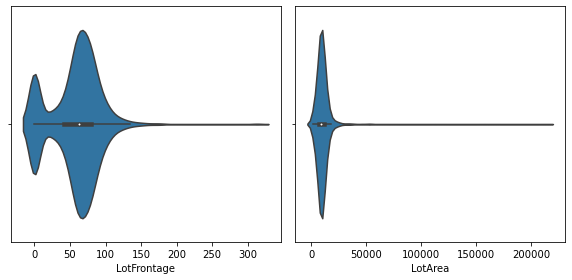

In [32]:
# Lot
plt.figure(figsize=(12,4), tight_layout=True)

plt.subplot(131)
sns.violinplot(house_df['LotFrontage'])

plt.subplot(132)
sns.violinplot(house_df['LotArea'])

plt.show()

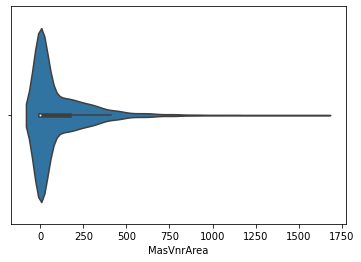

In [33]:
# Masonry veneer
sns.violinplot(house_df['MasVnrArea'])

plt.show()

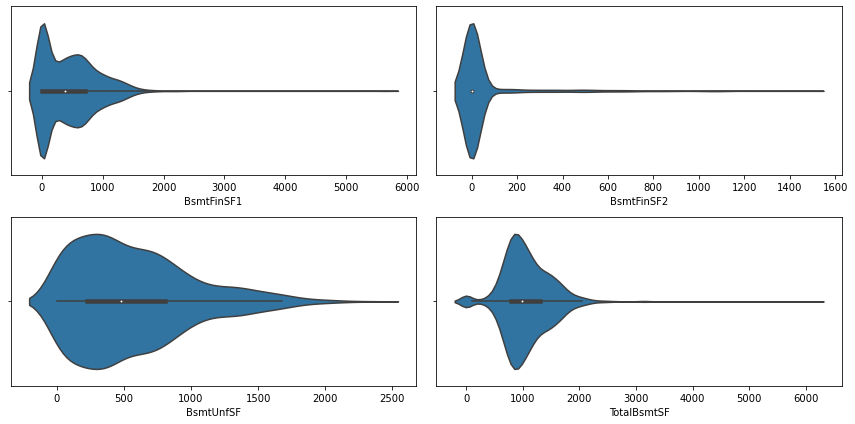

In [34]:
# Basement
plt.figure(figsize=(12,6), tight_layout=True)

plt.subplot(221)
sns.violinplot(house_df['BsmtFinSF1'])

plt.subplot(222)
sns.violinplot(house_df['BsmtFinSF2'])

plt.subplot(223)
sns.violinplot(house_df['BsmtUnfSF'])

plt.subplot(224)
sns.violinplot(house_df['TotalBsmtSF'])

plt.show()

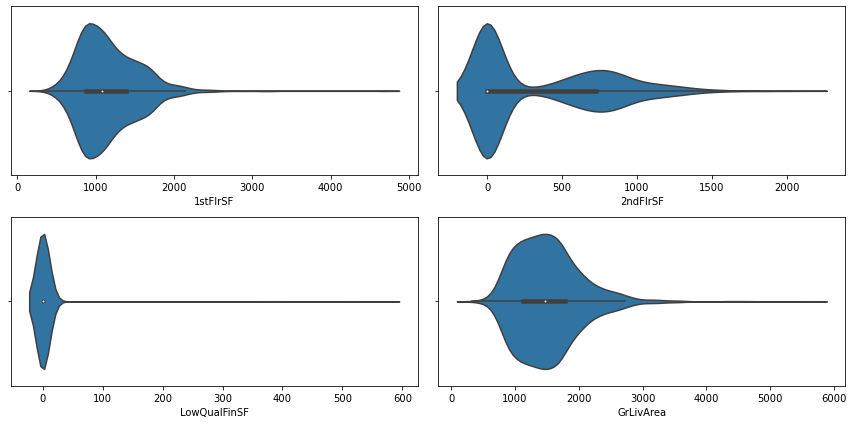

In [35]:
# Living area
plt.figure(figsize=(12,6), tight_layout=True)

plt.subplot(221)
sns.violinplot(house_df['1stFlrSF'])

plt.subplot(222)
sns.violinplot(house_df['2ndFlrSF'])

plt.subplot(223)
sns.violinplot(house_df['LowQualFinSF'])

plt.subplot(224)
sns.violinplot(house_df['GrLivArea'])

plt.show()

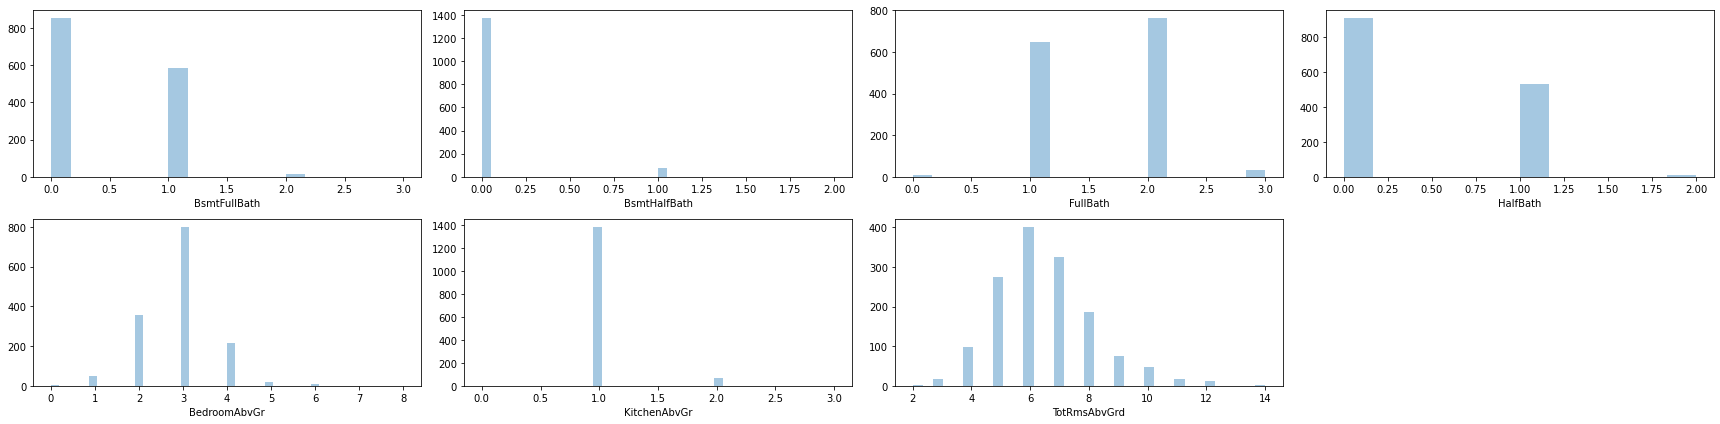

In [36]:
# Rooms
plt.figure(figsize=(24,6), tight_layout=True)

plt.subplot(241)
sns.distplot(house_df['BsmtFullBath'], kde=False)

plt.subplot(242)
sns.distplot(house_df['BsmtHalfBath'], kde=False)

plt.subplot(243)
sns.distplot(house_df['FullBath'], kde=False)

plt.subplot(244)
sns.distplot(house_df['HalfBath'], kde=False)

plt.subplot(245)
sns.distplot(house_df['BedroomAbvGr'], kde=False)

plt.subplot(246)
sns.distplot(house_df['KitchenAbvGr'], kde=False)

plt.subplot(247)
sns.distplot(house_df['TotRmsAbvGrd'], kde=False)

plt.show()

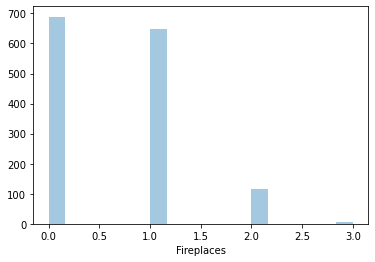

In [37]:
# Fireplaces
sns.distplot(house_df['Fireplaces'], kde=False)

plt.show()

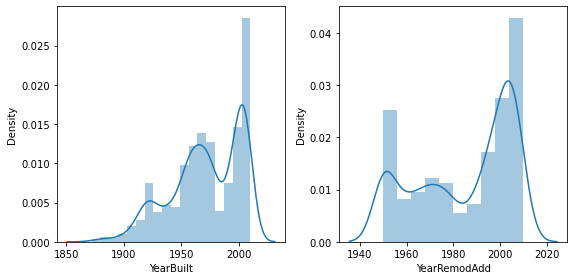

In [38]:
# Years
plt.figure(figsize=(12,4), tight_layout=True)

plt.subplot(131)
sns.distplot(house_df['YearBuilt'])

plt.subplot(132)
sns.distplot(house_df['YearRemodAdd'])

plt.show()

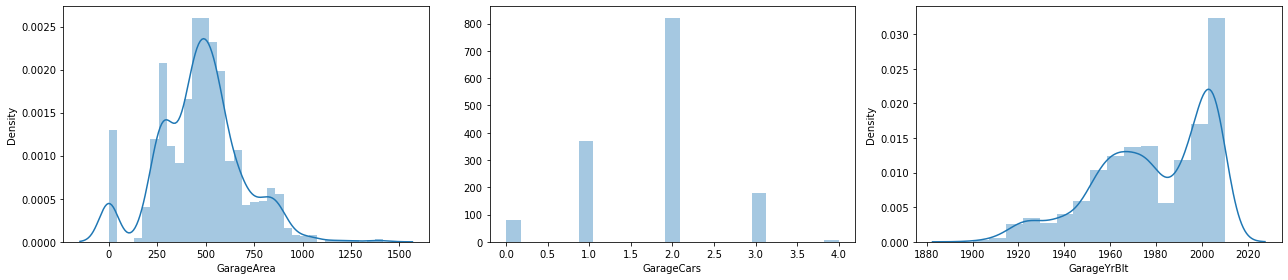

In [39]:
# Garage
plt.figure(figsize=(18,4), tight_layout=True)

plt.subplot(131)
sns.distplot(house_df['GarageArea'])

plt.subplot(132)
sns.distplot(house_df['GarageCars'], kde=False)

plt.subplot(133)
sns.distplot(house_df[house_df['GarageYrBlt'].notna()]['GarageYrBlt'])

plt.show()

## 2. Data Preparation

### Categories

In [40]:
# predictors
predictors = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
              'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
              'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
              'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
              'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
              'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
              'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
              'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
              '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal',
              'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

In [41]:
# split into X and y

# predictors in variable X
X = house_df.drop(['SalePrice'], axis=1)
X = X[predictors]

y = house_df['SalePrice'] # response variable in Y

In [42]:
# creating dummy variables for categorical variables

# subset all categorical variables
categories = X.select_dtypes(include=['object'])
categories.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,GarageType,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,CompShg,MetalSd,MetalSd,None,CBlock,GasA,SBrkr,Attchd,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,SBrkr,Detchd,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,WD,Normal


In [43]:
# convert into dummies
dummies = pd.get_dummies(categories, drop_first=True)
dummies.head()

,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [44]:
# replace category columns with generated dummy columns
X = X.drop(list(categories.columns), axis=1)
X = pd.concat([X, dummies], axis=1)

### Scaling

In [45]:
# we need to scale features for Ridge or Lasso

# columns names have to be saved as scale() removes them
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=210)

In [46]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Linear Regression Model

In [47]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [48]:
# coefficients and intercept
print(f'{lm.intercept_:.2e}')
print(lm.coef_)

-5.53e+11
[ 4.44400809e+02  5.61579720e+03  1.09812277e+04  7.99894919e+03
  8.15489346e+03 -9.08590184e+02  5.23965764e+03  3.41502564e+03
 -2.53851779e+03  6.56089753e+03 -2.84011815e+03  5.37999267e+03
  2.14893802e+02  9.32806936e+14 -1.02902350e+03  3.29561072e+14
  9.03002275e+14 -8.90330209e+14  7.90785210e+02 -1.02580199e+03
  5.45745226e+14  6.16364452e+14  6.87088023e+13 -7.42474181e+14
  9.72413833e+02 -1.83917981e+02 -5.38841038e+02  1.66505579e+03
 -4.69190021e+03 -1.48176327e+03  4.65232348e+03  7.13422753e+03
  4.27402360e+03  5.53161194e+03 -3.66374216e+03  1.13638791e+02
  3.87069651e+03  2.25361223e+03  1.80204496e+03 -3.08684389e+03
 -2.91374597e+02  4.98233674e+02  1.84810653e+02 -4.55088408e+02
  1.63630529e+03  1.02644894e+03 -6.33582540e+03  1.25038294e+04
 -3.71891342e+02  2.25418124e+03 -1.70645834e+03  1.28079498e+02
  5.68426188e+03 -3.09432346e+02 -1.87444484e+03  1.14414043e+04
  5.54788708e+03  1.80648007e+03  7.86067775e+03  1.35598009e+04
  1.96451582e+0

In [49]:
# error metrics
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

lm_metrics = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r²  train:', r2_train_lr)
lm_metrics.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r²  test :', r2_test_lr)
lm_metrics.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train:', rss1_lr)
lm_metrics.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test :', rss2_lr)
lm_metrics.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train:', mse_train_lr)
lm_metrics.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test :', mse_test_lr)
lm_metrics.append(mse_test_lr**0.5)

r²  train: 0.923778643881242
r²  test : -3.801186074581944e+17
rss train: 506837127304.2638
rss test : 9.681354957625523e+29
mse train: 497386778.5125258
mse test : 2.210355013156512e+27


## 4. Ridge Regression Model

In [50]:
params = {'alpha': [i for i in range(400,600,25)]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [400, 425, 450, 475, 500, 525, 550, 575]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [51]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [52]:
ridge = Ridge(alpha=model_cv.best_params_['alpha'])

ridge.fit(X_train, y_train)

# intercept and coefficients
print(f'{ridge.intercept_:.2e}')
print(ridge.coef_)

1.80e+05
[ 5.53692903e+02  3.19326889e+03  7.90352260e+03  2.63529152e+03
  1.71213979e+03  1.54958616e+03  3.93277665e+03  4.61474409e+03
 -8.74583289e+02  3.91429247e+03 -6.58812766e+02  4.30502515e+03
  2.66271375e+03  2.73504332e+03  2.17783857e+02  7.41767805e+02
  4.57796109e+01  3.18653038e+03  1.53777831e+03  4.52729218e+02
  5.25017430e+03  4.03899298e+03 -1.92407496e+02  7.19422884e+03
  2.01800240e+03  1.30531855e+02  3.37613870e+03  2.50164070e+03
 -1.26584531e+02 -1.29235868e+03  4.99123813e+03  5.15116735e+03
  2.06193154e+03  2.61993320e+03  2.39108197e+03  1.56183536e+03
  4.50518905e+03  3.04679147e+03 -4.48835837e+02 -9.35018314e+02
  1.27918488e+02  1.75350589e+03  6.77698226e+02 -7.08049465e+01
  1.02554438e+03  1.64436236e+03 -2.03691025e+02  8.07511267e+02
  5.62780971e+01  8.23283057e+01 -6.29906262e+02 -3.50224827e+01
 -1.36076480e+03 -4.18614809e+02 -8.39841988e+02  1.96050023e+03
 -2.34776477e+02  1.18230283e+02  1.23010390e+02  2.77889756e+02
  1.02912463e+03

In [53]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

rg_metrics = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r²  train:', r2_train_lr)
rg_metrics.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r²  test :', r2_test_lr)
rg_metrics.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train:', rss1_lr)
rg_metrics.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test :', rss2_lr)
rg_metrics.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train:', mse_train_lr)
rg_metrics.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test :', mse_test_lr)
rg_metrics.append(mse_test_lr**0.5)

r²  train: 0.8720284957364004
r²  test : 0.8773229266804157
rss train: 850951923457.1321
rss test : 312449921857.6582
mse train: 835085302.7057233
mse test : 713355985.9763886


## 5. Lasso Regression Model

In [54]:
params = {'alpha': [i for i in range(800,1_000,25)]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [800, 825, 850, 875, 900, 925, 950, 975]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [55]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 900}


In [56]:
lasso = Lasso(alpha=model_cv.best_params_['alpha'])
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([   -0.        ,  3960.34495078, 13851.22869881,  2837.25740585,
        2243.1910718 ,   322.47688406,  2737.30256978,  4831.62541206,
          -0.        ,  4275.88079154,   -64.79020304,  5697.07867727,
        2976.5337849 ,  1433.50758134,     0.        ,     0.        ,
          -0.        ,     0.        ,   745.18623862,     0.        ,
           0.        ,     0.        ,    -0.        , 24021.00117121,
        1985.99978658,     0.        ,  1632.5935054 ,  1056.28563888,
       -1478.0968644 , -2235.98103506,  6195.88114922,  3422.44272774,
        2366.61656484,  2767.9160867 ,     0.        ,   552.57892931,
        6840.90950784,     0.        ,    -0.        , -1472.97294779,
           0.        ,   248.32252764,     0.        ,    -0.        ,
         336.12097569,  1356.53332807,    -0.        ,    -0.        ,
          -0.        ,     0.        ,  -179.84722245,     0.        ,
        -224.52028639,    -0.        ,  -215.82624611,  4061.02693811,
      

In [57]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

ls_metrics = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r²  train:', r2_train_lr)
ls_metrics.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r²  test :', r2_test_lr)
ls_metrics.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train:', rss1_lr)
ls_metrics.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test :', rss2_lr)
ls_metrics.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train:', mse_train_lr)
ls_metrics.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test :', mse_test_lr)
ls_metrics.append(mse_test_lr**0.5)

r²  train: 0.8791347572844548
r²  test : 0.8848413965304327
rss train: 803698537105.9779
rss test : 293300905227.5724
mse train: 788712990.2904592
mse test : 669636769.9259644


## 6. Comparision and Evaluation

### Error metrics

In [58]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
           }

errors_df = pd.DataFrame(lr_table ,columns = ['Metric'] )
lm_series = pd.Series(lm_metrics, name = 'Linear Regression')
rg_series = pd.Series(rg_metrics, name = 'Ridge Regression')
ls_series = pd.Series(ls_metrics, name = 'Lasso Regression')

errors_df = pd.concat([errors_df, lm_series, rg_series, ls_series], axis = 1)

errors_df.set_index('Metric')

,Linear Regression,Ridge Regression,Lasso Regression
Metric,,,
R2 Score (Train),9.237786e-01,8.720285e-01,8.791348e-01
R2 Score (Test),-3.801186e+17,8.773229e-01,8.848414e-01
RSS (Train),5.068371e+11,8.509519e+11,8.036985e+11
RSS (Test),9.681355e+29,3.124499e+11,2.933009e+11
MSE (Train),2.230217e+04,2.889784e+04,2.808403e+04
MSE (Test),4.701441e+13,2.670872e+04,2.587734e+04


### Betas (coefficients)

In [59]:
betas = pd.DataFrame(index=X.columns)

In [60]:
betas.rows = X.columns

In [61]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [62]:
pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,4.444008e+02,5.536929e+02,-0.000000
LotArea,5.615797e+03,3.193269e+03,3960.344951
OverallQual,1.098123e+04,7.903523e+03,13851.228699
OverallCond,7.998949e+03,2.635292e+03,2837.257406
YearBuilt,8.154893e+03,1.712140e+03,2243.191072
YearRemodAdd,-9.085902e+02,1.549586e+03,322.476884
MasVnrArea,5.239658e+03,3.932777e+03,2737.302570
ExterQual,3.415026e+03,4.614744e+03,4831.625412
ExterCond,-2.538518e+03,-8.745833e+02,-0.000000
BsmtQual,6.560898e+03,3.914292e+03,4275.880792


In [63]:
betas[betas.Ridge.abs() > 1].Ridge.sort_values()

Condition2_PosN         -3685.147671
BldgType_TwnhsE         -3180.584752
Neighborhood_Edwards    -2643.439472
Exterior2nd_Stucco      -2285.292775
LotShape_IR3            -2091.935606
RoofStyle_Gable         -1925.413047
Neighborhood_Gilbert    -1901.788521
BldgType_Twnhs          -1854.421674
Condition1_Feedr        -1776.423588
Neighborhood_NAmes      -1641.969757
Neighborhood_CollgCr    -1497.990984
MSSubClass_160          -1360.764799
Neighborhood_MeadowV    -1338.866768
Neighborhood_NWAmes     -1302.616870
KitchenAbvGr            -1292.358680
Neighborhood_Mitchel    -1258.110011
Neighborhood_OldTown    -1051.004922
Exterior1st_HdBoard      -971.508990
GarageCond               -935.018314
Foundation_Wood          -925.338508
LotConfig_FR2            -922.061873
Exterior2nd_Wd Shng      -888.116030
MSSubClass_80            -879.318250
ExterCond                -874.583289
MSSubClass_190           -839.841988
MSZoning_RM              -835.992519
Neighborhood_IDOTRR      -833.517733
E

In [64]:
betas[betas.Ridge.abs() > 1].Ridge.abs().sort_values(ascending=False).head(10)

OverallQual             7903.522602
GrLivArea               7194.228843
Neighborhood_NoRidge    6558.210333
Neighborhood_NridgHt    6254.363974
1stFlrSF                5250.174304
TotRmsAbvGrd            5151.167349
RoofMatl_WdShngl        5034.456243
KitchenQual             4991.238134
ExterQual               4614.744094
GarageCars              4505.189049
Name: Ridge, dtype: float64

In [65]:
betas[betas.Lasso.abs() > 1].Lasso.sort_values()

Condition2_PosN         -5177.065435
BldgType_TwnhsE         -4246.127710
Exterior2nd_Stucco      -3266.736013
BldgType_Twnhs          -3164.143933
RoofStyle_Gable         -2612.495206
KitchenAbvGr            -2235.981035
LotShape_IR3            -1813.986245
BedroomAbvGr            -1478.096864
GarageCond              -1472.972948
MasVnrType_BrkFace      -1127.476147
Exterior2nd_Wd Shng      -855.777883
Condition1_Feedr         -785.894971
Exterior1st_HdBoard      -746.381168
Neighborhood_Edwards     -667.349427
Exterior1st_Wd Sdng      -621.597774
Neighborhood_OldTown     -568.134794
Foundation_Wood          -521.062460
Heating_OthW             -463.523074
LotConfig_FR3            -385.774800
Neighborhood_NWAmes      -369.791251
MSZoning_RM              -330.033145
SaleCondition_Family     -227.067073
MSSubClass_160           -224.520286
MSSubClass_190           -215.826246
MoSold                   -179.847222
HouseStyle_2.5Unf        -116.147598
BsmtCond                  -64.790203
C

In [66]:
betas[betas.Lasso.abs() > 1].Lasso.abs().sort_values(ascending=False).head(10)

GrLivArea               24021.001171
OverallQual             13851.228699
Neighborhood_NridgHt    10206.733480
Neighborhood_NoRidge     9279.950929
GarageCars               6840.909508
RoofMatl_WdShngl         6460.176629
KitchenQual              6195.881149
Neighborhood_StoneBr     5715.460128
BsmtExposure             5697.078677
Condition2_PosN          5177.065435
Name: Lasso, dtype: float64

## Doubling  alpha (lambda) for Ridge and Lasso

In [67]:
ridge = Ridge(alpha=1000)

ridge.fit(X_train, y_train)

# intercept and coefficients
print(f'{ridge.intercept_:.2e}')
print(ridge.coef_)

1.80e+05
[ 9.48902085e+02  2.60860826e+03  6.58335114e+03  1.78441032e+03
  1.59390532e+03  1.84657887e+03  3.52995858e+03  4.45522370e+03
 -5.23725166e+02  3.30318082e+03 -2.91092670e+02  3.50184073e+03
  2.34826995e+03  2.70452215e+03  2.94715630e+02  5.95278130e+02
  4.14374354e+02  3.47417000e+03  1.67354312e+03  5.86594858e+02
  4.78300437e+03  3.14091375e+03 -2.02301580e+02  6.10438666e+03
  1.83105807e+03  2.41691088e+01  3.14329240e+03  2.14724702e+03
  4.18725295e+02 -9.47056619e+02  4.61650479e+03  4.50039233e+03
  1.48085277e+03  2.68965488e+03  2.72236352e+03  1.76511277e+03
  3.95790217e+03  3.25844106e+03 -1.35166173e+02 -3.83868902e+02
  1.90930434e+02  1.89462770e+03  9.83796473e+02 -8.27464960e+01
  7.63300600e+02  1.47449271e+03  7.26961142e+01  6.76935533e+02
 -1.97174040e+02 -3.32306890e+00 -3.62112196e+02 -6.60931513e+00
 -1.24409993e+03 -4.44530152e+02 -6.35823761e+02  1.23607703e+03
 -6.07392186e+02  3.46433855e+01  9.19215953e+01  2.13912621e+01
  1.31606225e+03

In [68]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

rg_metrics = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r²  train:', r2_train_lr)
rg_metrics.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r²  test :', r2_test_lr)
rg_metrics.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train:', rss1_lr)
rg_metrics.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test :', rss2_lr)
rg_metrics.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train:', mse_train_lr)
rg_metrics.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test :', mse_test_lr)
rg_metrics.append(mse_test_lr**0.5)

r²  train: 0.8519181161189184
r²  test : 0.866749332343175
rss train: 984676742239.4419
rss test : 339380126785.3464
mse train: 966316724.4744278
mse test : 774840472.1126629


In [69]:
lasso = Lasso(alpha=1800)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([    0.        ,  3441.0382832 , 15578.19936975,   922.36978523,
        1303.88224262,  1114.62699492,  1916.64596605,  6094.61647553,
          -0.        ,  3225.18181725,    -0.        ,  5494.48036792,
        2184.20135425,  1735.65307398,     0.        ,     0.        ,
          -0.        ,     0.        ,   446.02272743,     0.        ,
           0.        ,     0.        ,    -0.        , 24319.17683017,
        1191.9536881 ,     0.        ,   252.13157565,     0.        ,
          -0.        ,  -602.44979066,  6995.66662109,  1078.79238204,
        1356.35469024,  2910.62451271,     0.        ,   713.07297002,
        6703.74834579,     0.        ,    -0.        ,    -0.        ,
           0.        ,    31.34589463,     0.        ,    -0.        ,
           0.        ,   776.78308061,    -0.        ,    -0.        ,
          -0.        ,     0.        ,    -0.        ,     0.        ,
        -936.28631463,    -0.        ,    -0.        ,  4872.6186952 ,
      

In [70]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

ls_metrics = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r²  train:', r2_train_lr)
ls_metrics.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r²  test :', r2_test_lr)
ls_metrics.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train:', rss1_lr)
ls_metrics.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test :', rss2_lr)
ls_metrics.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train:', mse_train_lr)
ls_metrics.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test :', mse_test_lr)
ls_metrics.append(mse_test_lr**0.5)

r²  train: 0.8595022497288131
r²  test : 0.8780194110140042
rss train: 934245725426.4946
rss test : 310676024993.9967
mse train: 916826030.8405247
mse test : 709305993.1369787


In [71]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
print(betas[betas.Ridge.abs() > 1].Ridge.abs().sort_values(ascending=False).head(1))
print()
print(betas[betas.Lasso.abs() > 1].Lasso.abs().sort_values(ascending=False).head(1))

OverallQual    6583.351144
Name: Ridge, dtype: float64

GrLivArea    24319.17683
Name: Lasso, dtype: float64
